In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [3]:
import os
import datetime
import math

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.utils.fileutils import get_project_root
from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels, dense_to_events, single_track_labels
from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
from src.data.annotations import class_color_map


In [4]:
project_root = get_project_root()

In [5]:

annotations = load_dataset_annotations().sort_index(level=(0, 1))
annotations.head(3)

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping TUT_annotation_notes.md
skipping File-3.wav
skipping File-2.wav
skipping File-1.wav


start       end annotation annotator
dataset clip   index                                         
bcn     File-1 0      0.478360  0.557077       coug       NaN
               1      0.932499  0.986995       coug       NaN
               2      1.362417  1.980046       peop       NaN

In [6]:
annotations.loc['bcn'].annotation.value_counts().head(20)

peop     2456
rtn      1150
brak      810
door      731
rare      671
horn       93
busd       63
coug       20
blin       20
bkmu       18
musi       16
troll      11
sire        9
whtl        8
Name: annotation, dtype: int64

In [7]:
from src.data.annotations import load_noise_classes

m = load_noise_classes()
m.noise.value_counts()

other           41
speech          19
road_traffic    16
rail_traffic     5
biophony         5
geophony         4
music            4
Name: noise, dtype: int64

In [8]:
# Load from files
soundlevels = pandas.read_parquet(os.path.join(project_root, 'data/processed/soundlevels/LAS.parquet')).droplevel(0).sort_index(level=(0, 1))
soundlevels


level
dataset clip   time                             
bcn     File-1 0 days 00:00:00        -56.752438
               0 days 00:00:00.250000 -57.079689
               0 days 00:00:00.500000 -57.055588
               0 days 00:00:00.750000 -56.784978
               0 days 00:00:01        -56.633011
...                                          ...
tut     b093   0 days 00:03:29.500000 -53.015915
               0 days 00:03:29.750000 -53.112149
               0 days 00:03:30        -53.103120
               0 days 00:03:30.250000 -53.007961
               0 days 00:03:30.500000 -52.817005

[101389 rows x 1 columns]

In [9]:
spectrograms = pandas.read_parquet(os.path.join(project_root, 'data/processed/spectrograms/logmels-64bands-256hop.parquet')).droplevel(0).sort_index(level=(0, 1))
spectrograms.columns = [ float(c) for c in spectrograms.columns ]
spectrograms.loc['bcn']


50.0       97.0       144.0      191.0   \
clip   time                                                                    
File-1 0 days 00:00:00            75.354301  40.264588  76.681526  57.855943   
       0 days 00:00:00.005333333  85.899166  40.264588  77.180887  58.355304   
       0 days 00:00:00.010666666  84.803897  40.264588  79.412479  60.586895   
       0 days 00:00:00.015999999  89.866249  40.264588  86.690475  67.864892   
       0 days 00:00:00.021333332  82.702117  40.264588  79.690053  60.864469   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  87.833317  43.427678  86.426477  67.600894   
       0 days 02:04:12.996867521  74.799723  43.427678  82.120245  63.294661   
       0 days 02:04:13.002200854  96.926584  43.427678  91.646232  72.820648   
       0 days 02:04:13.007534187  94.582902  43.427678  78.398016  59.572432   
       0 days 02:04:13.012867520  93.655711  43.427678  88.626240  69.800657   

                                     238.0      285.0      333.0      380.0   \
clip   time                                                                    
File-1 0 days 00:00:00            74.900643  63.477136  72.566953  63.974655   
       0 days 00:00:00.005333333  74.064127  62.640620  62.953525  54.361227   
       0 days 00:00:00.010666666  76.064268  64.640761  68.306854  59.714556   
       0 days 00:00:00.015999999  78.324031  66.900524  62.551029  53.958731   
       0 days 00:00:00.021333332  76.402392  64.978885  64.245343  55.653045   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  92.531957  81.108450  94.627142  86.034844   
       0 days 02:04:12.996867521  77.280003  65.856496  87.006258  78.413960   
       0 days 02:04:13.002200854  85.088287  73.664780  83.352523  74.760225   
       0 days 02:04:13.007534187  82.236768  70.813261  87.768295  79.175997   
       0 days 02:04:13.012867520  77.719569  66.296062  89.422612  80.830314   

                                     427.0      474.0   ...     5168.0  \
clip   time                                             ...              
File-1 0 days 00:00:00            70.122628  63.411246  ...  46.815062   
       0 days 00:00:00.005333333  61.104361  54.392979  ...  40.773293   
       0 days 00:00:00.010666666  71.555665  64.844283  ...  42.285892   
       0 days 00:00:00.015999999  71.888591  65.177209  ...  45.449112   
       0 days 00:00:00.021333332  72.392779  65.681397  ...  43.184711   
...                                     ...        ...  ...        ...   
File-3 0 days 02:04:12.991534188  92.312114  85.600732  ...  50.081347   
       0 days 02:04:12.996867521  93.312181  86.600799  ...  47.024207   
       0 days 02:04:13.002200854  87.220218  80.508836  ...  48.614321   
       0 days 02:04:13.007534187  90.751456  84.040074  ...  50.235158   
       0 days 02:04:13.012867520  91.703365  84.991983  ...  65.625109   

                                     5425.0     5695.0     5978.0     6275.0  \
clip   time                                                                    
File-1 0 days 00:00:00            43.864919  40.264588  40.676000  40.264588   
       0 days 00:00:00.005333333  41.647647  44.904879  40.565675  40.264588   
       0 days 00:00:00.010666666  43.532511  41.312809  40.264588  40.264588   
       0 days 00:00:00.015999999  46.011247  44.281818  40.264588  40.264588   
       0 days 00:00:00.021333332  43.264915  42.896581  40.264588  40.264588   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  49.158074  53.393084  50.171414  44.798626   
       0 days 02:04:12.996867521  50.041445  50.765505  54.113088  51.863249   
       0 days 02:04:13.002200854  47.964192  51.685694  52.727913  52.351534   
       0 days 02:04:13.007534187  50.095956  49.903331  51.222043  48.827656   
       0 days 02:04:13.012867520

In [55]:

files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()
files = files[files.dataset == 'bcn']

all_classes = list(m.index)

from src.features.soundlevel import compute_intermittency_ratio, compute_event_impacts
from src.data.annotations import clip_events

def compute_class_impacts(events, levels, window='1min'):

    e = events.copy()
    e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')
    e['impact'] = compute_event_impacts(e, levels, window=window)

    # FIXME: is summing here sane? 
    pos_impacts = e[e.impact > 0.0]
    s = pos_impacts.groupby('noise_class').impact.sum()

    print(s)
    
    return s

def analysis(row):
    idx = tuple(row)
    l = soundlevels.loc[idx]
    e = annotations.loc[idx]

    s = compute_class_impacts(e, l)
    return s
    
from src.utils.dataframe import flatten_dataframes
files.apply(analysis, axis=1)

#flatten_dataframes(files.apply(analysis, axis=1))


noise_class
other           0.141801
road_traffic    1.971708
speech          0.016341
Name: impact, dtype: float64
noise_class
other           0.028331
road_traffic    1.640126
speech          0.114092
Name: impact, dtype: float64
noise_class
music           0.002794
other           0.122481
road_traffic    1.128790
speech          0.174152
Name: impact, dtype: float64


noise_class        music     other  road_traffic    speech
dataset clip                                              
bcn     File-1       NaN  0.141801      1.971708  0.016341
        File-2       NaN  0.028331      1.640126  0.114092
        File-3  0.002794  0.122481      1.128790  0.174152

KeyboardInterrupt: 

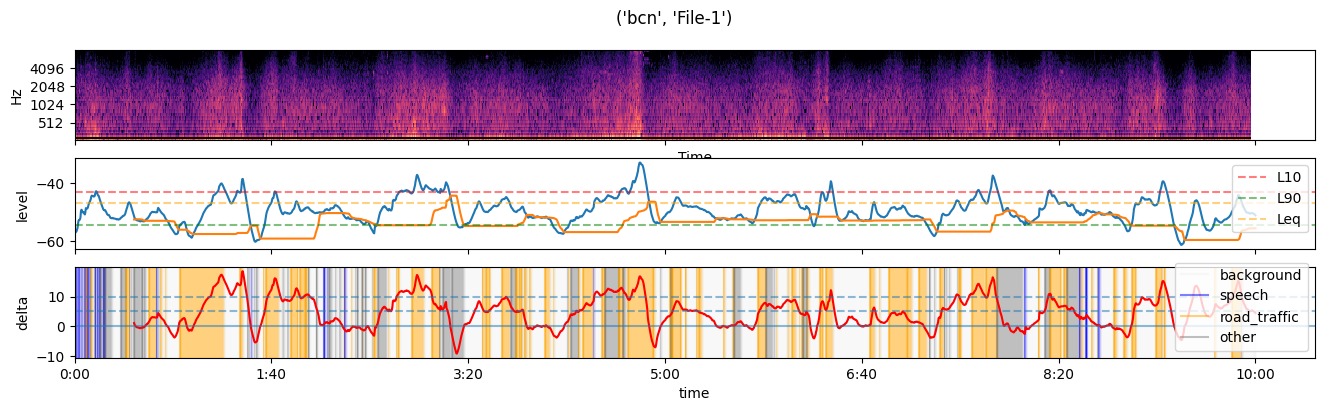

Error in callback <function flush_figures at 0x7d055158d4e0> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d05a2d0d0d0>>
Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [47]:

def compute_metric(levels, metric):
    from src.features.soundlevel import compute_ln, compute_leq

    if metric == 'Leq':
        level = float(compute_leq(levels.values))
    elif metric.startswith('L'):
        ln = float(metric[1:])
        level = compute_ln(levels, n=ln)   
    else:
        raise ValueError("Unsupported ")

    return level

def plot_clip(levels, spec, ann, title='',
              soundlevel_summary=['L10', 'L90', 'Leq'],
              soundlevel_summary_colors={'L10': 'red', 'Leq': 'orange', 'L90': 'green'},
             ):

    from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
    from src.features.spectrogram import plot_spectrogram
    from src.data.annotations import class_color_map

    aspect = 4.0
    height = 4.0
    width = aspect * height
    fig, (spec_ax, level_ax, label_ax) = plt.subplots(3, figsize=(width, height), sharex=True)

    # spectrogram
    plot_spectrogram(spec_ax, spec)
    
    # soundlevels
    from src.features.soundlevel import compute_background
    ll = compute_background(levels.level, window=30.0)
    ll = ll.reset_index()
    ll['time'] = ll['time'] / pandas.Timedelta(seconds=1)
    seaborn.lineplot(ax=level_ax, data=ll, y='level', x='time')
    seaborn.lineplot(ax=level_ax, data=ll, y='background', x='time')

    for metric in soundlevel_summary:
        metric_level = compute_metric(levels, metric)
        color = soundlevel_summary_colors.get(metric, 'gray')
        level_ax.axhline(metric_level, ls='--', alpha=0.5, color=color, label=metric)

    level_ax.legend()
    

    # annotations
    classes=all_classes
    time_resolution=0.100

    ann['noise_class'] = ann.annotation.map(m.noise.to_dict()).fillna('unknown')
    last = ann['end'].max()
    multi = make_continious_labels(ann, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)

    single = single_track_labels(multi)
    seaborn.lineplot(ax=label_ax, data=ll, y='delta', x='time', color='red')
    label_ax.axhline(0.0, ls='-', alpha=0.5)
    label_ax.axhline(5.0, ls='--', alpha=0.5)
    label_ax.axhline(10.0, ls='--', alpha=0.5)
    plot_single_track_labels(label_ax, single, colors=class_color_map, alpha=0.5)

    if title:
        fig.suptitle(title)


files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()
files = files[files.dataset == 'bcn']

all_classes = list(m.index)

from src.features.soundlevel import compute_intermittency_ratio, compute_event_impacts

def plot(row):
    # select a subset of data
    start = pandas.Timedelta(minutes=0)
    end = pandas.Timedelta(minutes=10.0)
    idx = tuple(row)
    l = soundlevels.loc[idx].loc[start:end]
    s = spectrograms.loc[idx].loc[start:end]
    e = annotations.loc[idx].copy()
    e = clip_events(e, start=start/pandas.Timedelta(seconds=1), end=end/pandas.Timedelta(seconds=1))
    e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')

    plot_clip(l, s, e, title=f'{str(idx)}')

files.apply(plot, axis=1)


In [78]:


from src.data.annotations import make_multitrack_labels, single_track_labels
from src.features.soundlevel import compute_background

def resample_soundlevels(levels: pandas.DataFrame, freq='100ms'):
    """
    Resamples up or down, based on what is needed

    NOTE: soundlevels should be a time-integrated value.
    Resampling assumes the data is smooth.
    """
    target_freq = pandas.Timedelta(freq)
    
    original_freq = levels.index.freq
    if original_freq is None:
        original_freq = pandas.Series(levels.index).diff().iloc[1]

    # TODO: consider setting some sanity checks
    if target_freq <= original_freq:
        out = levels.resample(target_freq).ffill() # XXX: use interpolate instead?
    else:
        out = levels.resample(target_freq).mean()

    return out


def map_levels_to_labels(annotations : pandas.DataFrame,
                         soundlevels : pandas.DataFrame,
                         classes,
                         background_window_seconds=30.0,
                         event_limit_db=5.0):
    '''
    Combine soundlevels with annotations and categorize each point in time as
    
    "background"
    event
        of known class
        "unknown"
        "mixed"
    '''

    # convert annotations into a single track
    multi_track = make_multitrack_labels(annotations, classes=all_classes)
    
    # NOTE: all overlapped annotations will be considered "mixed"
    # disregards for example the decibel levels of each annotation
    # very eager to combined into mixed. Conservative wrt claim to be able to explain things as single
    # If problematic, clean up the annotations beforehand
    single_track = single_track_labels(multi_track)
    single_track.name = 'label'
    single_track = single_track.to_frame()
    
    # compute background levels and delta
    soundlevels = resample_soundlevels(soundlevels)
    sb = compute_background(soundlevels.level, window=background_window_seconds)
    
    # merge the resampled levels with the labels
    df = single_track.merge(sb, how='left', left_index=True, right_index=True)

    assert len(df) == len(single_track)
    
    # mark timestamps where delta exceeds +5db (sound events)
    is_event = df['delta'] >= event_limit_db
    
    # if a timestamp is NOT an event, label it as background
    df['label'] = df['label'].where(is_event, other='background')

    # if a timestamp is labelled as "background", but also a sound event - re-label to "unknown"
    is_unknown = (df['label'] == 'background') & (is_event)
    df['label'] = df['label'].mask(is_unknown, other='unknown')

    return df



def plot(row):
    idx = tuple(row)
    l = soundlevels.loc[idx]
    e = annotations.loc[idx].copy()
    e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')
    e['impact'] = compute_event_impacts(e, l, window='1min')

    sb = compute_background(l.level, window=60.0)

    levels = []
    def extract_from_series(event, series=None, agg='mean'):
        start = pandas.Timedelta(seconds=event['start'])
        end = pandas.Timedelta(seconds=event['end'])
        event_data = series.loc[start:end]
        value = event_data.agg(agg)
        return value
    
    e['delta_max'] = e.apply(extract_from_series, axis=1, series=sb.delta, agg='max')
    e['delta_mean'] = e.apply(extract_from_series, axis=1, series=sb.delta, agg='mean')
    e.index.name = 'event'

    return e

events_with_impacts = files.apply(plot, axis=1)
events_with_impacts = flatten_dataframes(events_with_impacts)
events_with_impacts

start          end annotation annotator  \
dataset clip   event                                                  
bcn     File-1 0         0.478360     0.557077       coug       NaN   
               1         0.932499     0.986995       coug       NaN   
               2         1.362417     1.980046       peop       NaN   
               3         2.403909     2.658227       peop       NaN   
               4         2.876213     3.336407       peop       NaN   
...                           ...          ...        ...       ...   
        File-3 1314   7428.201018  7429.844898       peop       NaN   
               1315   7430.420256  7431.653166       peop       NaN   
               1316   7438.777819  7442.565631       brak       NaN   
               1317   7443.099810  7444.216729       brak       NaN   
               1318   7445.819265  7452.715026       peop       NaN   

                       noise_class    impact  delta_max  delta_mean  
dataset clip   event                                                 
bcn     File-1 0            speech -0.000136        NaN         NaN  
               1            speech  0.000000        NaN         NaN  
               2            speech -0.000259        NaN         NaN  
               3            speech -0.000120        NaN         NaN  
               4            speech -0.000208        NaN         NaN  
...                            ...       ...        ...         ...  
        File-3 1314         speech  0.000154   1.203337    0.956113  
               1315         speech  0.000491   3.106470    2.369025  
               1316   road_traffic  0.000578   2.037882    0.776820  
               1317   road_traffic -0.000218  -1.837137   -2.011724  
               1318         speech -0.001968  -0.015350   -1.528755  

[6076 rows x 8 columns]

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


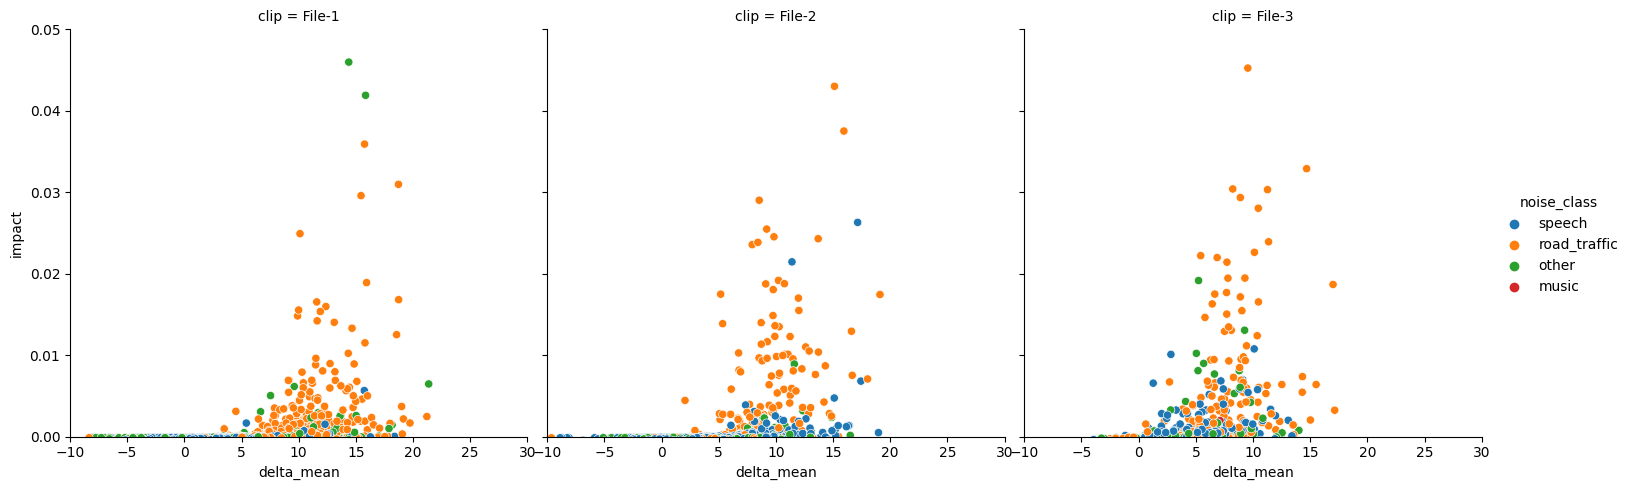

In [82]:
g = seaborn.relplot(data=events_with_impacts.reset_index(), y='impact', x='delta_mean', col='clip', hue='noise_class')
g.set(ylim=(0.0, 0.05), xlim=(-10, 30))